# Part 1: Linear Classifier
-------

In [130]:
import torch
from torch import nn

# Hyperparameters Test 1
batch_size = 2048
learning_rate=1e-1
nepochs = 50
hidden=[3072, 3072]
LossFunction = nn.CrossEntropyLoss()
bias = True
save_weights = nepochs - 5

# Input size
ninputs=3*32*32

# Output size
nout=10

# Use GPU if avaiable
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 2070 SUPER


In [131]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torch.utils.data import random_split

cifar10_dataset = datasets.CIFAR10(root='./', # here
                               train=True, # train split
                               download=True, # we want to get the data
                               transform=T.ToTensor(), # put it into tensor format
                              )

# Split the data into a training data set, validation set, and a test set - first get sizes
# CIFAR10 has 50000 images, so I'll split the data up into 37500 for training, 7500 for validation
# and 5000 for testing
train_data_size = 40000
val_data_size = 10000

# Randomsplit with will split the data from cifar10 dataset into train and validation set 
train_dataset, val_dataset = random_split(cifar10_dataset, [train_data_size, val_data_size])

# We can now load the data with DataLoader from these datasets 
train_data = DataLoader(train_dataset,
                        batch_size=batch_size,
                        )

val_data = DataLoader(val_dataset,
                      batch_size=batch_size,
                      )


Files already downloaded and verified


## Linear Model

In [132]:
from torch import optim
from tqdm import tqdm, notebook # This is optional but useful
from torchvision import datasets
import matplotlib.pyplot as plt

class LinearNet(nn.Module):
    def __init__(self,
                 ninputs=3*32*32,
                 hidden=[512],
                 nout=10,
                ):
        super().__init__()
        net = []
        # Input layer
        net.append(nn.Linear(ninputs, hidden[0], bias=bias))
        net.append(nn.ReLU())
        
        # Hidden layers
        if len(hidden) > 1:
          for i in range(len(hidden) - 1):
            net.append(nn.Linear(hidden[i], hidden[i+1], bias=bias))
            net.append(nn.ReLU())

        # Output Layer
        net.append(nn.Linear(hidden[-1], nout, bias=bias))
        net.append(nn.ReLU())
        net.append(nn.Softmax(dim=1))
        self.net = nn.Sequential(*net)
        
    def forward(self, x):
        b, c, h, w = x.shape
        x = x.view(b, -1) # Flatten image
        x = self.net(x)
        return x

### Training

LinearNet(
  (net): Sequential(
    (0): Linear(in_features=3072, out_features=3072, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3072, out_features=3072, bias=True)
    (3): ReLU()
    (4): Linear(in_features=3072, out_features=10, bias=True)
    (5): ReLU()
    (6): Softmax(dim=1)
  )
)


Epoch:   0%|          | 0/50 [00:00<?, ?epoch/s]

Epoch 0: loss: 2.3016293048858643
Epoch 1: loss: 2.3004064559936523
Epoch 2: loss: 2.299044370651245
Epoch 3: loss: 2.2975902557373047
Epoch 4: loss: 2.2958309650421143
Epoch 5: loss: 2.2932186126708984
Epoch 6: loss: 2.2896766662597656
Epoch 7: loss: 2.285290241241455
Epoch 8: loss: 2.2801434993743896
Epoch 9: loss: 2.274221658706665
Epoch 10: loss: 2.267435312271118
Epoch 11: loss: 2.259962320327759
Epoch 12: loss: 2.252427577972412
Epoch 13: loss: 2.245478868484497
Epoch 14: loss: 2.239366054534912
Epoch 15: loss: 2.2340564727783203
Epoch 16: loss: 2.2294347286224365
Epoch 17: loss: 2.225339412689209
Epoch 18: loss: 2.2216360569000244
Epoch 19: loss: 2.218200922012329
Epoch 20: loss: 2.214956521987915
Epoch 21: loss: 2.2118377685546875
Epoch 22: loss: 2.208812952041626
Epoch 23: loss: 2.205869674682617
Epoch 24: loss: 2.2029757499694824
Epoch 25: loss: 2.2001068592071533
Epoch 26: loss: 2.1972689628601074
Epoch 27: loss: 2.194443464279175
Epoch 28: loss: 2.1916394233703613
Epoch 29:

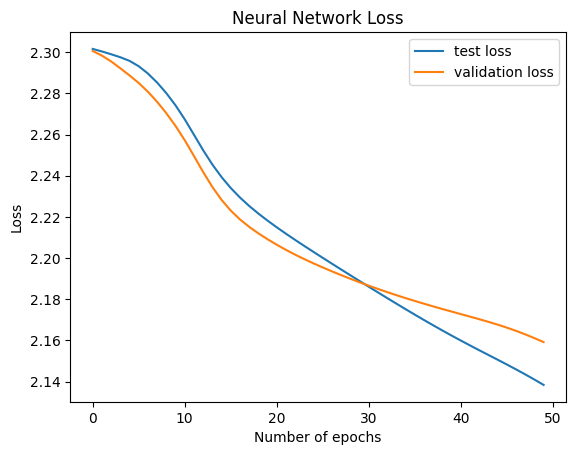

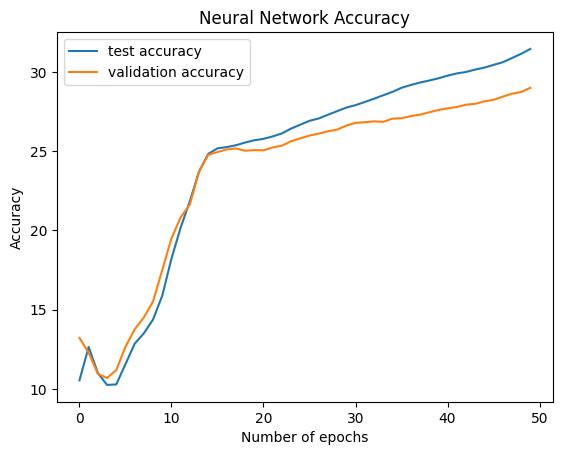

In [133]:
model = LinearNet(ninputs=ninputs,
                  hidden=hidden,
                  nout=nout).to(device)
print(model)
# We need an optimizer that tells us what form of gradient descent to do
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


loss_history = []
acc_history = []
val_loss_history = []
val_acc_history = []
for epoch in notebook.trange(nepochs,
                  desc="Epoch",
                  unit="epoch",
                  disable=False):
    correct = 0
    total = 0
    model.train()
    for (data, label) in tqdm(train_data,
                              desc="iteration",
                              unit="%",
                              disable=True):
        optimizer.zero_grad(set_to_none=True)
        data = data.to(device)
        label = label.to(device)
        out = model(data)
        loss = LossFunction(out, label)
        loss.backward()
        optimizer.step()
    
        # Used chatGPT to help write this accuracy code     
        _, predicted = torch.max(out.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
        
    accuracy = 100 * correct / total
    acc_history.append(accuracy)
    loss_history.append(loss.item())
    print(f"Epoch {epoch}: loss: {loss.item()}")
    
    if (epoch >= save_weights): # Save tensor information once we get towards the end
        torch.save(model.state_dict(), "model_epoch_{}.pt".format(epoch))
    
    
    # Validation
    correct = 0
    total = 0
    model.eval() # No longer training - comparing loss and accuracy in our validation set
    with torch.no_grad(): # Don't want to update the gradients
        for (data, label) in tqdm(val_data,
                              desc="iteration",
                              unit="%",
                              disable=True):
            data = data.to(device)
            label = label.to(device)
            out = model(data)
            loss = LossFunction(out, label)

            # Used chatGPT to help write this accuracy code     
            _, predicted = torch.max(out.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            
        accuracy = 100 * correct / total
        val_acc_history.append(accuracy)
        val_loss_history.append(loss.item())            
          

plt.plot(loss_history, label='test loss')
plt.plot(val_loss_history, label='validation loss')
plt.title("Neural Network Loss")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(acc_history, label='test accuracy')
plt.plot(val_acc_history, label='validation accuracy')
plt.title("Neural Network Accuracy")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Test Model Accuracy

In [120]:
cifar10_test_dataset = datasets.CIFAR10(root='./', # here
                               train=False, # train split
                               download=True, # we want to get the data
                               transform=T.ToTensor(), # put it into tensor format
                              )

test_data = DataLoader(cifar10_test_dataset,
                       batch_size=batch_size,
                       )

model.eval()
accuracy = 0
for (data, label) in test_data:
    data = data.to(device)
    label = label.to(device)
    out = model(data)
    answers = out.max(dim=1)[1]
    accuracy += (answers == label).sum()
print(f"Total accuracy = {accuracy / len(cifar10_test_dataset)*100:.2f}%")

Total accuracy = 38.30%


# Part 1 Results:
-------

**Notice - I accidentally used 'test loss/accuracy' in most of my graphs, when this should be train set**

I initially started with a batch size of 32, learning rate of .01, a single hidden layer that was double the size of the input layer. This model was trained for 20 epochs (which clearly wasn't long enough) and the results I got were pretty poor, as seen in the two images below showing the loss and accuracy as training went on.

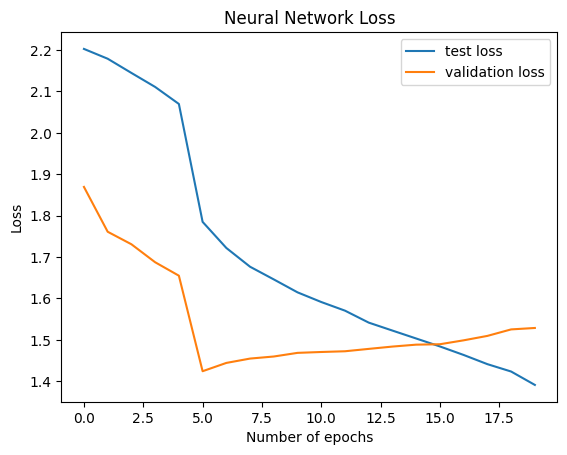
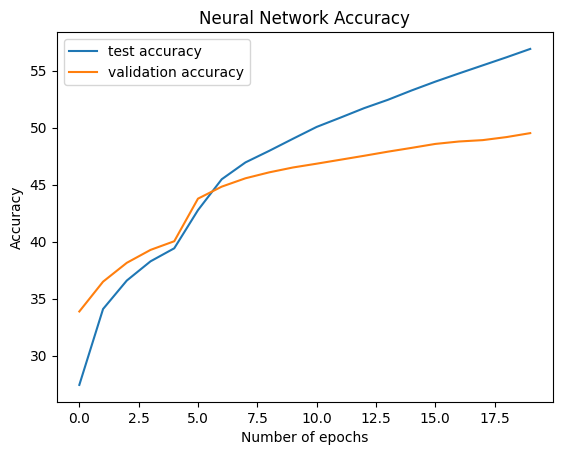

The time taken to train was 2m 51.8s and I ultimately got a 52% accuracy on the test set.

With this in mind, I wanted to compare between having a bias and not having a bias - so I changed the training time from 20 epochs to 50 epochs and compared the difference between the two.

#### No Bias:
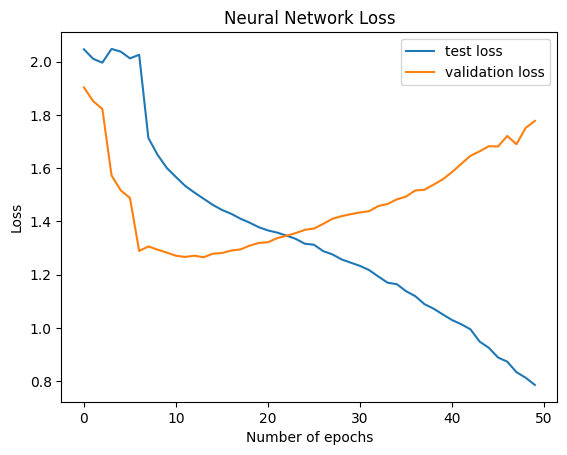
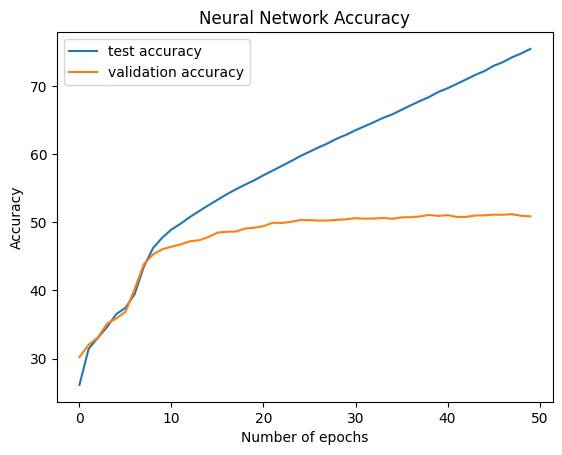

Test Accuracy: 49.88%

#### Bias:
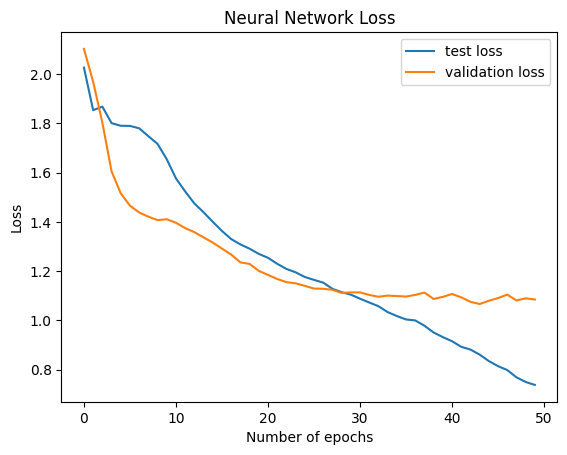
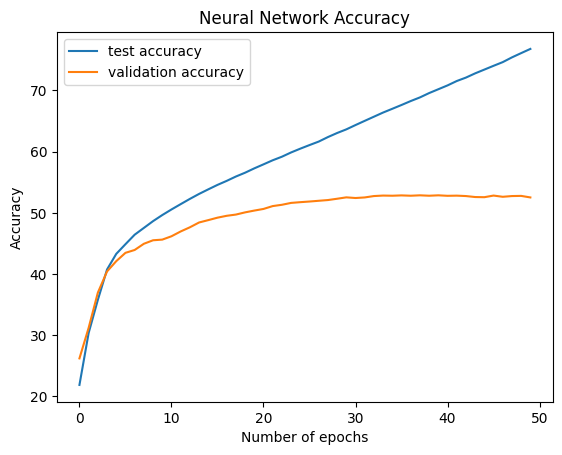

Test Accuracy: 51.47%

Both of these tests took around 6m50s. The results show that adding the bias term somewhat improved overfitting as test accuracy improved. However, based on the accuracy graph between the training set and the validation set, it's clear that the model is still overfitting quite a bit. 

Based on these results, I want to reduce the number of epochs for now since I currently have an overfitting model - and I need to reduce the training time to mess with other parameters.

With this in mind, I'll reduce the number of epochs to 20, since overfitting seems to begin around epoch 10. I'm also going to reduce the first hidden layer to 3072, the same size as the input layer, and add a second layer with the same size. I'm assuming this may actually end up increasing overfitting since I'm adding a second layer. Also - I want to point out that I didn't intentionally choose a batch size of 32 for the sake of avoiding overfitting, but I realize now that this is an ideal batch size to use to help reduce overfitting since it shows less images through forward propagation, and updates the gradient based off of smaller batch sizes - allowing for a more sets of examples to be seen and train off that finding the gradient.

With the new updated parameters (20 epochs, two hidden layers, 3072 sized) the results are as follow:
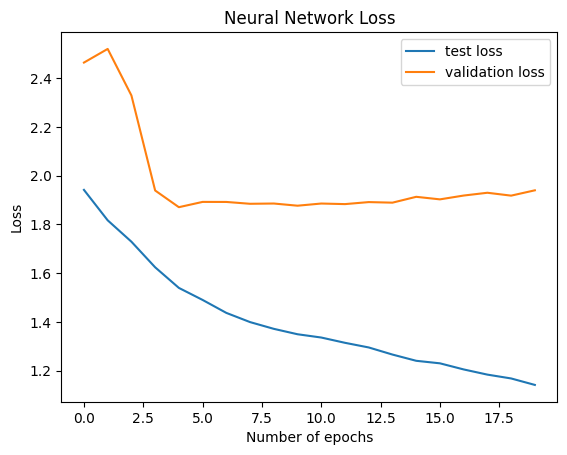
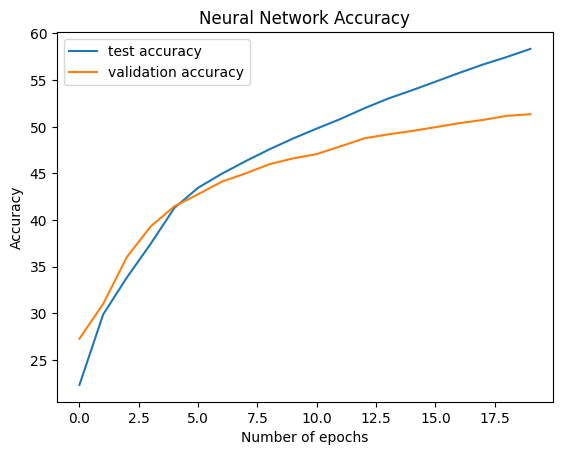

Test Accuracy: 57.62% 

As expected this really didn't improve much, the model begins to overfit around epoch 10. I'm now going to test test to see how reducing the model's complexity will affect the results - seeing how accuracy is still going up on the training set I'm hoping that this will help with the overfitting issue somewhat. Reduced to a single hidden layer, 3072.

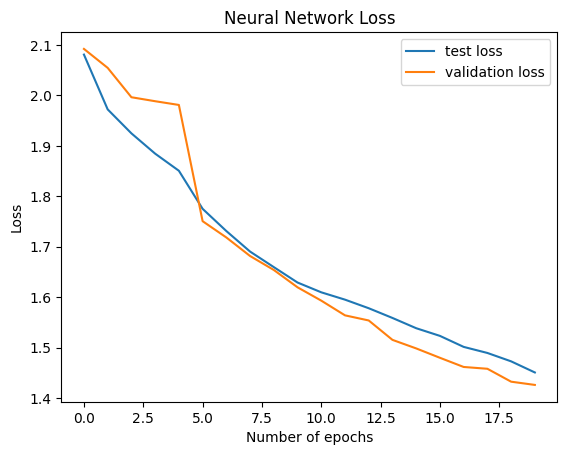
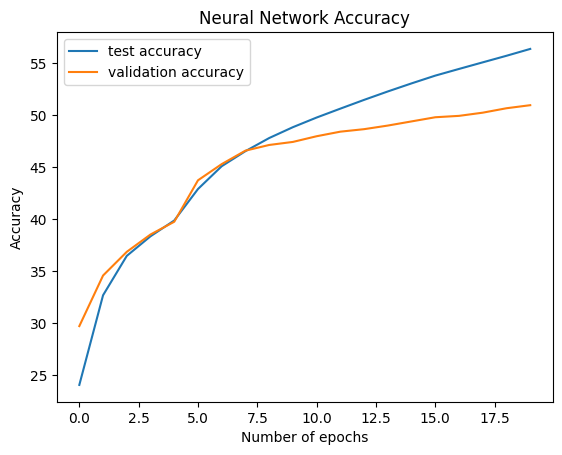

Test Accuracy: 57.41%

Training for longer clearly shows how much this model is overfitting. Based on how the validation set's loss increases the way it does, I would say that the learning rate is too high here, but since it's not training on this data I don't think this is the case.

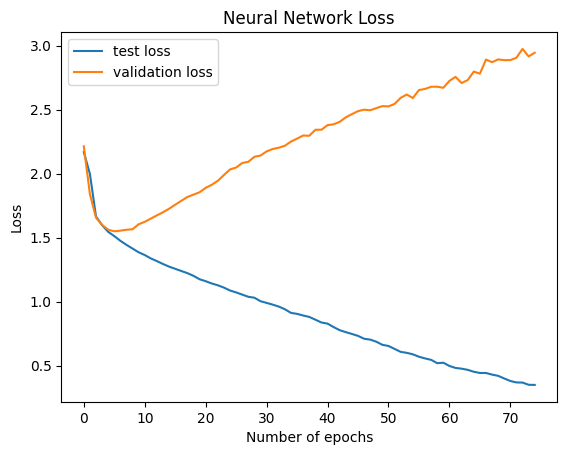
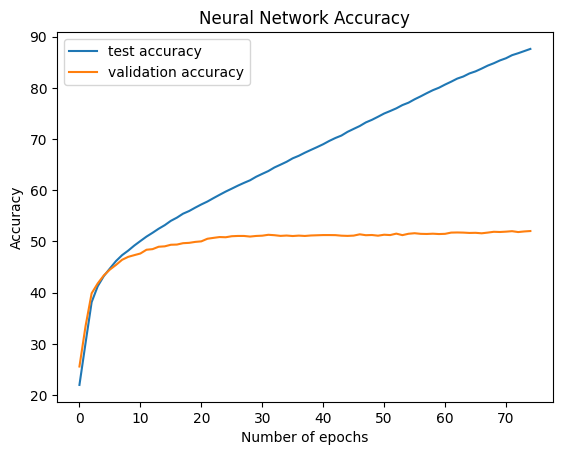

Test Accuracy: 52.70% 

When adding Softmax to my model, convergence slows down a ton, and although validation and test accuracy are quite close together it starts settling towards the 40% accuracy. My assumption as to why this is much slower is because gradients are very small when doing back propagation due to the output being between 0 and 1, instead of using the ReLU where the number could be a lot larger. I've spent some time with this, and I couldn't get any better results than this. I also ran this with the sigmoid activation function and got similar results.

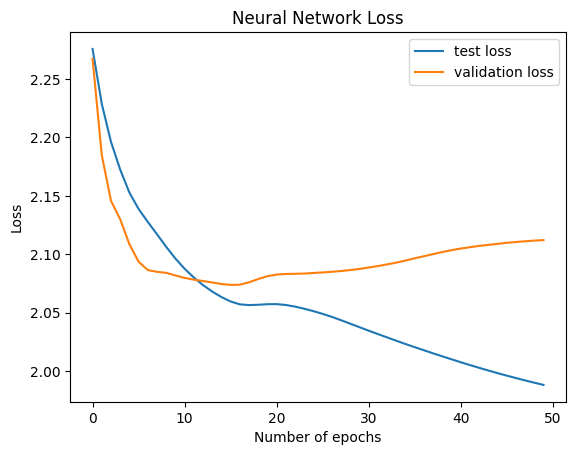
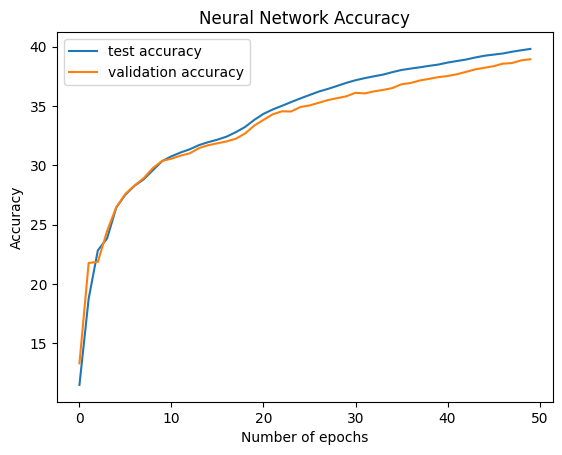

Test Accuracy: 38.30% 

### Sigmoid: 
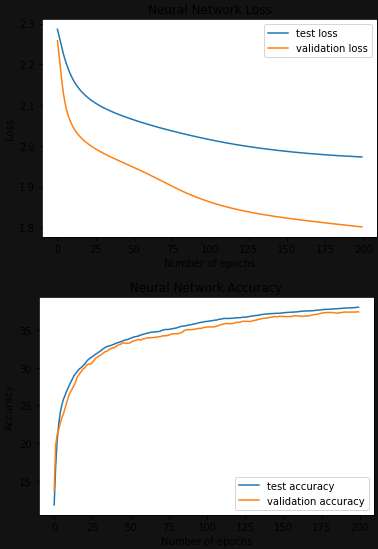

I trained for longer on both of these models, trying different batch sizes and learning rates and couldn't find anything that would converge on a lower loss given my compute. I've realized now (coming back to this) that this model is underfitting quite a bit, and needs to be more complex ideally if I want a higher accuracy. However, sigmoid probably isn't the best choice as an activation function since this is a more complex problem and will likely result in vanishing gradient (as seen in the graphs - it's converging at a low %).

Here's an example with higher batch size (1024 for Sigmoid and 2048 for Softmax)

### Softmax: 
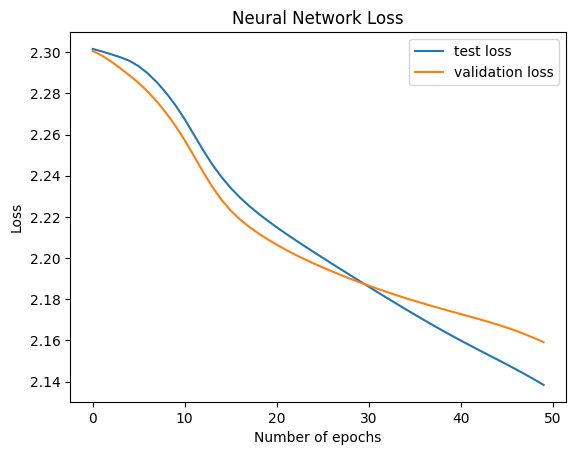
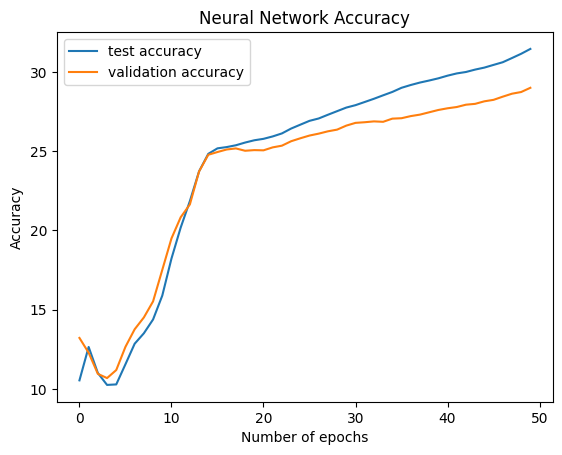

Training time of 5 minutes

### Sigmoid:
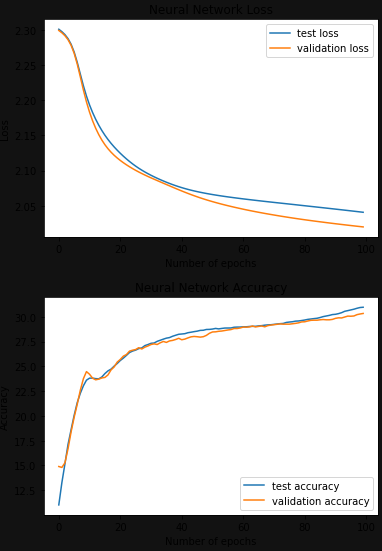

Training time of 11 minutes

Ultimately, using ReLU() with a fairly simple model - one hidden layer with a size of 3072 - gave me the best results in terms of convergence. However, it began to overfit after 50% accuracy and in almost all models I trained it began overfitting after around epoch 10. 


# Part 2 - Convolutional Classifier
-----

In [157]:
import torch
from torch import nn

# Parameters
batch_size = 64
nepochs = 20
LossFunction = nn.CrossEntropyLoss()

#l2
# wd = .01 # Penalty to larger weights to help prevent overfitting

save_weights = nepochs - 5


channels=3

# Output size
nout=10

# Use GPU if avaiable
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))

    # torch.cuda.set_per_process_memory_fraction(0.8, device=0)
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 2070 SUPER


In [182]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torch.utils.data import random_split

# Augmentation

augmented = T.Compose([
  T.RandomHorizontalFlip(),
  T.RandomCrop((28,28), padding=4),
  T.ToTensor(),
  T.Normalize((.5,.5,.5), (.5,.5,.5))
])

cifar10_dataset = datasets.CIFAR10(root='./', # here
                               train=True, # train split
                               download=True, # we want to get the data
                               transform=augmented, # put it into tensor format
                              )


"""cifar10_dataset = datasets.CIFAR10(root='./', # here
                               train=True, # train split
                               download=True, # we want to get the data
                               transform=T.ToTensor(), # put it into tensor format
                              )"""

# Split the data into a training data set, validation set, and a test set - first get sizes
# CIFAR10 has 50000 images, so I'll split the data up into 37500 for training, 7500 for validation
# and 5000 for testing
train_data_size = 40000
val_data_size = 10000

# Randomsplit with will split the data from cifar10 dataset into train, and validation set
train_dataset, val_dataset = random_split(cifar10_dataset, [train_data_size, val_data_size])

# We can now load the data with DataLoader from these datasets 
train_data = DataLoader(train_dataset,
                        batch_size=batch_size,
                        )

val_data = DataLoader(val_dataset,
                      batch_size=batch_size,
                      )


Files already downloaded and verified


## CNN Model - Scratch

In [185]:
class SimpleConv(nn.Module):
    def __init__(self,
               input_channels=3,
              ):
      super().__init__()
      self.conv = nn.Sequential(nn.Conv2d(input_channels, 32, kernel_size=3, padding=1, stride=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=2),
                                nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=2),
                                nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=2),
                               )
      self.fc = nn.Sequential(nn.Dropout(p=0.5),
                              nn.Linear(1152, 2048),
                              nn.ReLU(),
                              nn.Linear(2048, 10),
                              nn.ReLU(),
                              # nn.Softmax(dim=1),
                             )
    def forward(self, x):
        x = self.conv(x)
        b, c, h, w = x.shape
        x = x.view(b, -1)
        x = self.fc(x)
        
        
        
        return x

### Training

SimpleConv(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1152, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=10, bias=True)
    (4): ReLU()
  )
)


Epoch:   0%|          | 0/25 [00:00<?, ?epoch/s]

Epoch 0: loss: 1.8924320936203003
Val Acc: 29.97%
Epoch 1: loss: 1.8539040088653564
Val Acc: 37.07%
Epoch 2: loss: 1.7960790395736694
Val Acc: 41.48%
Epoch 3: loss: 1.7296048402786255
Val Acc: 48.2%
Epoch 4: loss: 1.3467497825622559
Val Acc: 50.99%
Epoch 5: loss: 1.509321689605713
Val Acc: 51.25%
Epoch 6: loss: 1.4701697826385498
Val Acc: 54.72%
Epoch 7: loss: 1.265341877937317
Val Acc: 57.99%
Epoch 8: loss: 1.138489842414856
Val Acc: 60.18%
Epoch 9: loss: 1.0273187160491943
Val Acc: 61.81%
Epoch 10: loss: 1.0952584743499756
Val Acc: 61.68%
Epoch 11: loss: 1.042598843574524
Val Acc: 62.49%
Epoch 12: loss: 1.0195426940917969
Val Acc: 64.02%
Epoch 13: loss: 1.0080705881118774
Val Acc: 64.88%
Epoch 14: loss: 1.009933590888977
Val Acc: 65.54%
Epoch 15: loss: 1.2774665355682373
Val Acc: 66.73%
Epoch 16: loss: 1.0176126956939697
Val Acc: 67.25%
Epoch 17: loss: 0.9960221648216248
Val Acc: 67.68%
Epoch 18: loss: 0.8304430842399597
Val Acc: 67.84%
Epoch 19: loss: 1.0783920288085938
Val Acc: 67.

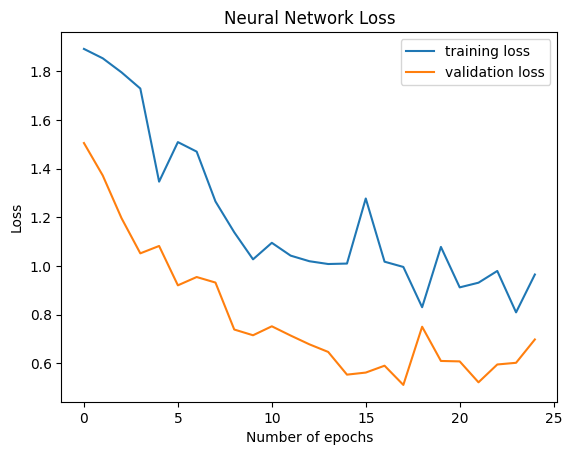

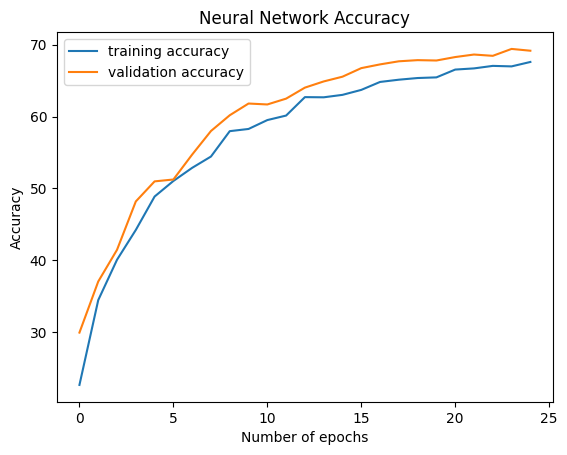

In [190]:
from torch import optim
from tqdm import tqdm, notebook # This is optional but useful
from torchvision import datasets
import matplotlib.pyplot as plt

torch.cuda.empty_cache()
model = SimpleConv().to(device)

print(model)
# model.load_state_dict(torch.load("ok_wow.pt"))

nepochs=25
wd = .0025
learning_rate=1e-1
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=wd)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=.65)

loss_history = []
acc_history = []
val_loss_history = []
val_acc_history = []
for epoch in notebook.trange(nepochs,
                  desc="Epoch",
                  unit="epoch",
                  disable=False):
    correct = 0
    total = 0
    model.train()
    for (data, label) in tqdm(train_data,
                              desc="iteration",
                              unit="%",
                              disable=True):
        optimizer.zero_grad(set_to_none=True)
        data = data.to(device)
        label = label.to(device)
        out = model(data)
        loss = LossFunction(out, label)
        
        loss.backward()
        optimizer.step()
    
        # Used chatGPT to help write this accuracy code     
        _, predicted = torch.max(out.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
    
    scheduler.step()
          
    accuracy = 100 * correct / total
    acc_history.append(accuracy)
    loss_history.append(loss.item())
    print(f"Epoch {epoch}: loss: {loss.item()}")
    if (epoch >= epoch - 10): # Save tensor information once we get towards the end
        torch.save(model.state_dict(), "model_epoch_{}.pt".format(epoch))
    
    
    # Validation
    model.eval() # No longer training - comparing loss and accuracy in our validation set
    correct = 0
    total = 0
    with torch.no_grad(): # Don't want to update the gradients
        for (data, label) in val_data:
            data = data.to(device)
            label = label.to(device)
            out = model(data)
            loss = LossFunction(out, label)

            # Used chatGPT to help write this accuracy code     
            _, predicted = torch.max(out.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            
        accuracy = 100 * correct / total
        val_acc_history.append(accuracy)
        val_loss_history.append(loss.item())
        print(f"Val Acc: {accuracy}%")
            
          

plt.plot(loss_history, label='training loss')
plt.plot(val_loss_history, label='validation loss')
plt.title("Neural Network Loss")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(acc_history, label='training accuracy')
plt.plot(val_acc_history, label='validation accuracy')
plt.title("Neural Network Accuracy")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [161]:
cifar10_test_dataset = datasets.CIFAR10(root='./', # here
                               train=False, # train split
                               download=True, # we want to get the data
                               transform=T.ToTensor(), # put it into tensor format
                              )

test_data = DataLoader(cifar10_test_dataset,
                       batch_size=batch_size,
                       )
# model = SimpleConv().to(device)
model.load_state_dict(torch.load("model_epoch_24.pt"))

model.eval()
accuracy = 0
for (data, label) in test_data:
    data = data.to(device)
    label = label.to(device)
    out = model(data)
    answers = out.max(dim=1)[1]
    accuracy += (answers == label).sum()
print(f"Total accuracy = {accuracy / len(cifar10_test_dataset)*100:.2f}%")

Files already downloaded and verified
Total accuracy = 74.56%


# Results
------

I first started with a model from "scratch" (using the example from class as a starting point). I initially tested it with a high learning rate of .01, and three convolutional layers - all maintaining their image size, but increase in channel size by 12, 24, and 48. I then had my linear portion have a single hidden layer with a size of 3072 - although I feel like this should have been larger since the input size is currently 48*32*32. Additionally, I decided to use Softmax activation at the end and see the difference between the Linear model I was using earlier. I trained on this for 20 epochs just to see what my result would be and this is what I got: 
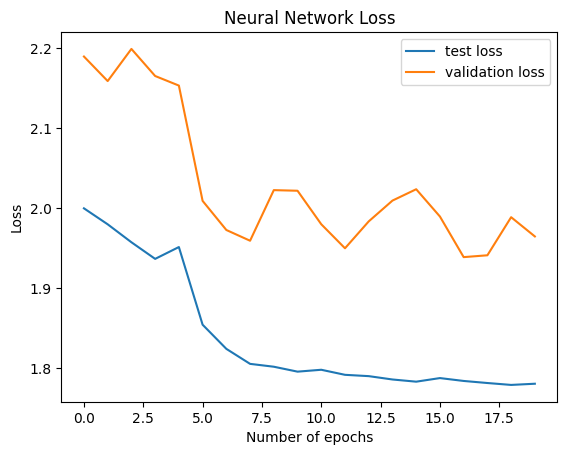
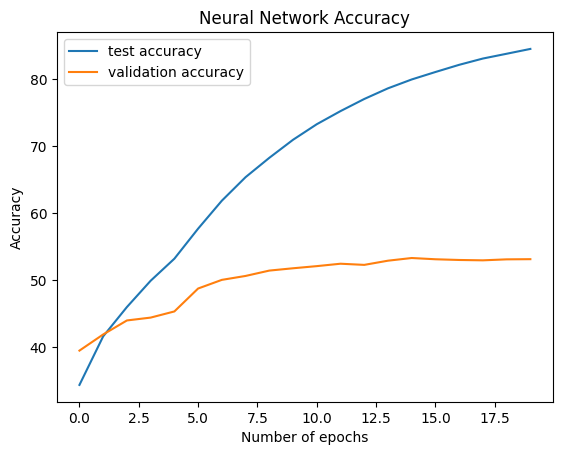

Test Accuracy: 53.10%, training time 8m 14.2s

In a shorter epoch period, compared to my linear model, the model converged better - which makes sense since we're using Convergence to extract features from the images, and then using the Linear portion on those features to classify. Training time takes much longer though, which makes sense since we're adding several convolutional layers, along with batch normalization at each layer. I used batch normalization first to try and help speed up the training process, to reduce variances in the distributions between each layer -- from what I know, having the distributions between each layer not as variant results in faster training time since the gradients aren't all over the place. Seeing how this model is overfitting, I want to attempt to add some regularization and keep all the same parameters - so I'll do L2 regularization by adding weight decay, set to .01.

Having done this, this resulting in my model performing much worse. For now, I'll remove it - I'm going to add ReLU and Maxpooling, and remove BatchNormalization. Additionally, I'm going to reduce the complexity of my model to have two convolutional layers (32 channels each). My max pooling will apply a 2x2 filter with a stride of 2. Additionally, I'm going to reduce the complexity of my linear layer by having a hidden layer with only 128 nodes.  

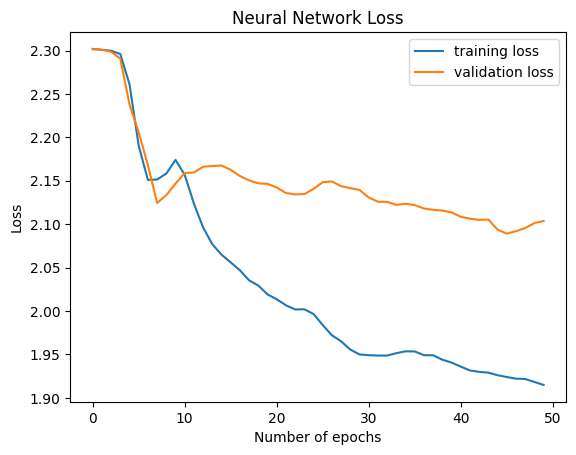
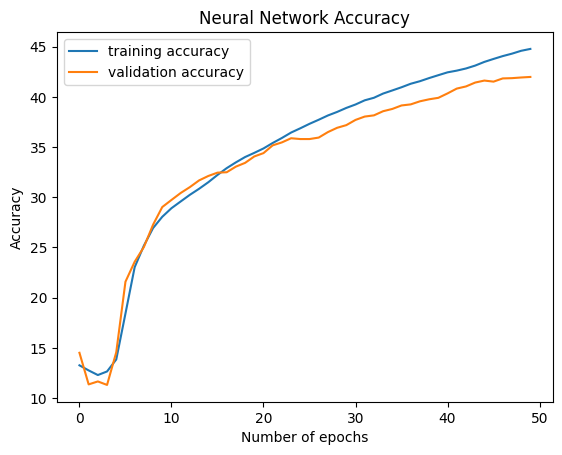

Test Accuracy: 41.32% 

This caused a lot slower convergence, and probably has to do with the reduction in complexity. I'm going to change my CNN to have three layers with 12, 24, and 36 channels - max pooling after each one resulting in a feature map being 576 outputs. My linear layer will then have two linear layers, double the size. I'm also doing ReLU after every Conv2D, then Maxpooling. The reason I'm doing max pooling is to reduce computation, but also to save important features and to help generalize since it only saves the most important features.

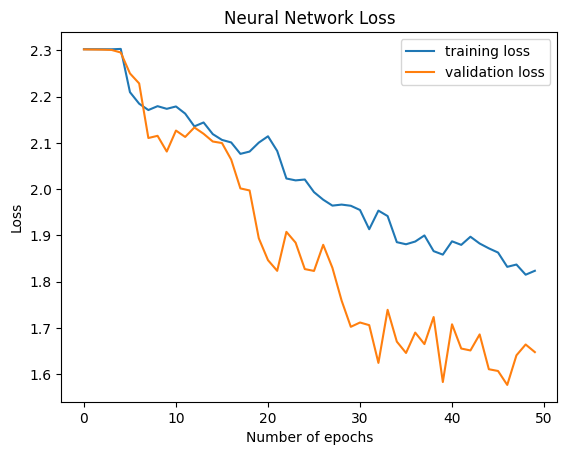
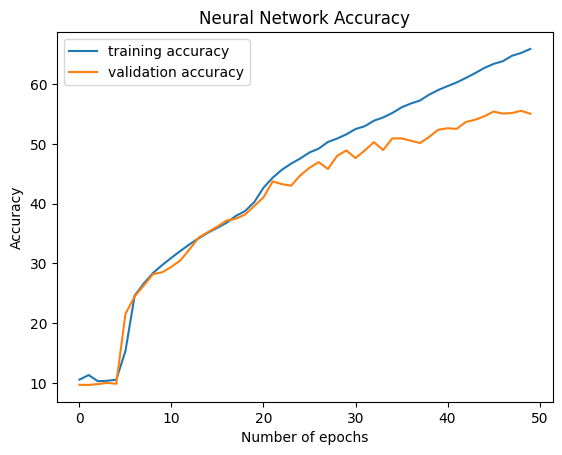

Test Accuracy: 56.82% 

It seems this has given me better generalization but overfitting begins to occur at around 20 epochs, or at least validation accuracy begins to separate from training accuracy. Using softmax, for some reason I just can't get good convergence, so I'm going to try this same model but removing softmax. Training took about 5 minutes.


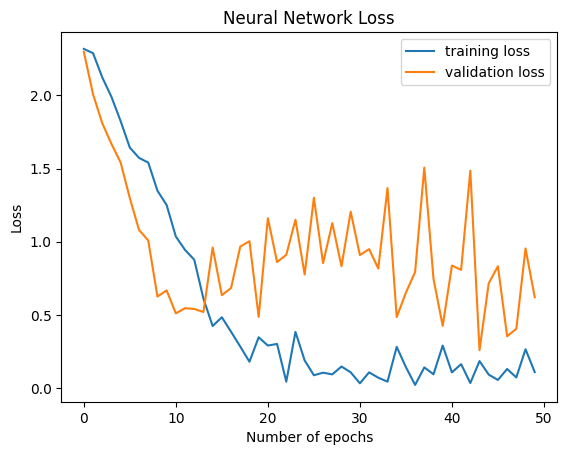
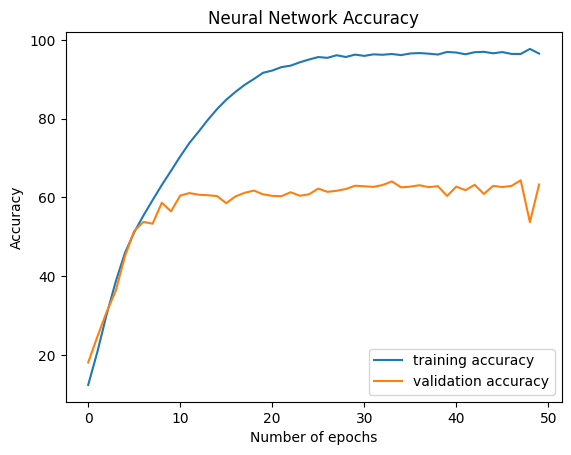

Test Accuracy: 63.98%

As a result, I got accuracy to go up, and additionally, it converged much faster. Overfitting is still occuring, however it's gotten to a higher % of accuracy which most likely is in part due to the feature maps, and it saving the more important features while reducing in size (max pooling). I wanted to see the difference between SGD and Adam, so I changed my optimizer to Adam and ran again (with a learning rate of .0001).

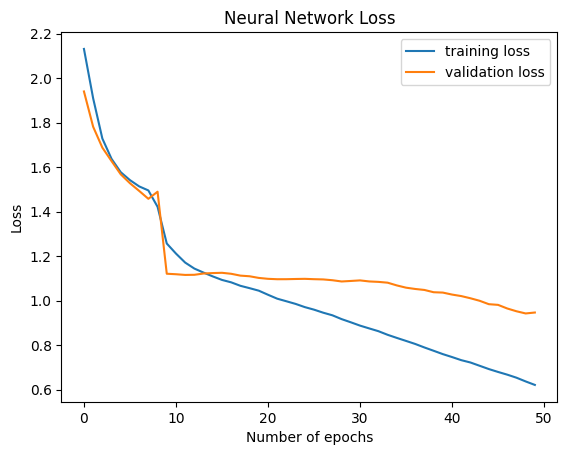
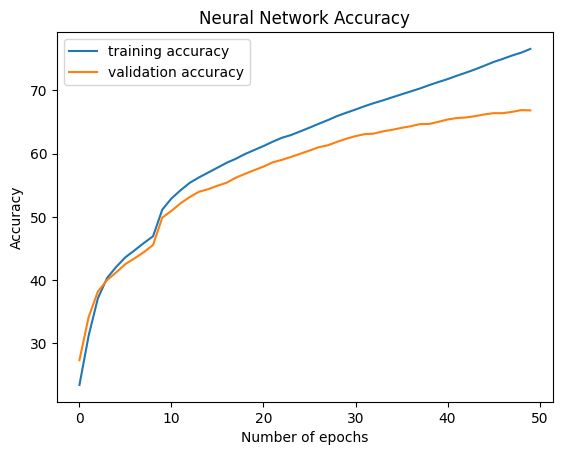

Test Accuracy: 67.78%,  Training time: 6m 4.0s

This resulted in better results, and less overfitting. One big difference here is that Adam seems to be more stable in that the loss is slowly decreased, but goes in the right direction the whole time and doesn't have huge swings like SGD does towards the end. This is somewhat in part due to SGD being heavily affected by learning rate and since the learning rate is fairly high (.1) it causes larger swings, while Adam is meant to reduce the learning rate as it gets closer to an optimum. 

To try and reduce overfitting some more, I reduced the batch size from 64, to 32. Also, keep in mind, this is what my model currently looks like:
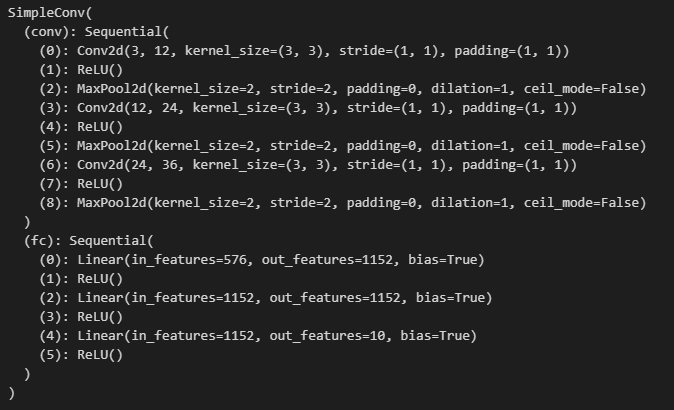

This took much longer to converge, and the results weren't worth showing since I didn't get any improvement, and rather got a pretty poor result. I was kind of expecting better results, in terms of more generalization since it was a smaller batch size.

I want to test is increasing the out channels in my CNN to see if I can somewhat reduce overfitting. I'm going to try three convolutional layers all with 36. 

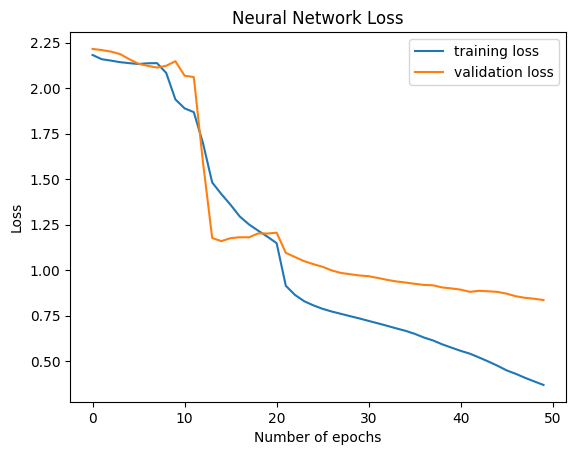
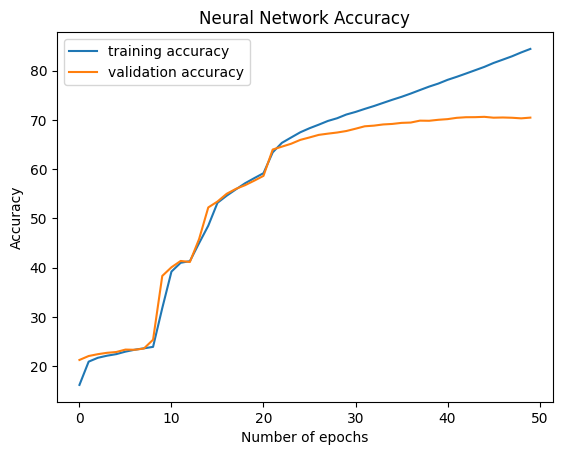

Test Accuracy: 70.16%

Seeing how this had a small affect, I'm going to add a fourth convolutional layer - with ReLU() and MaxPooling and reduce my hidden layer size in the linear portion slightly so I have out_features being 288, 500 and then back to 10. I don't want to reduce the complexity too much because this will result in a slower convergence, and possibly underfitting. I experimented at first with one layer of 288, but this caused pretty slow convergence and ultimately underfitting. Having done this, training took about 10 minutes (75 epochs) and I saw a decrease in accuracy. Overfitting occuring around epoch 20. 

I also want to mention that I tried this model with Softmax and it takes a lot longer to converge - which makes sense since it's using a lot smaller output (0-1) to calculate loss and results in smaller gradients. Training on 75 epochs got me this (9 minutes to train) - 
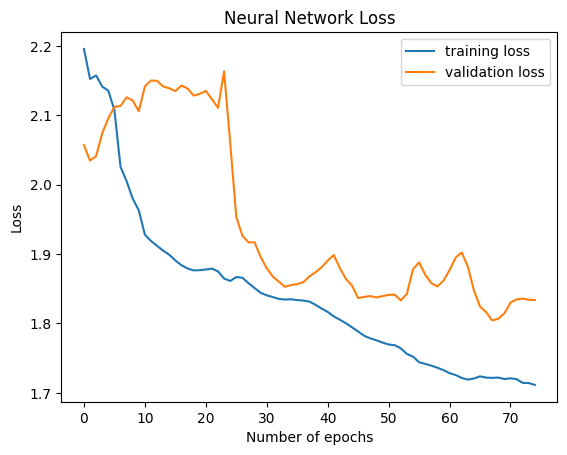
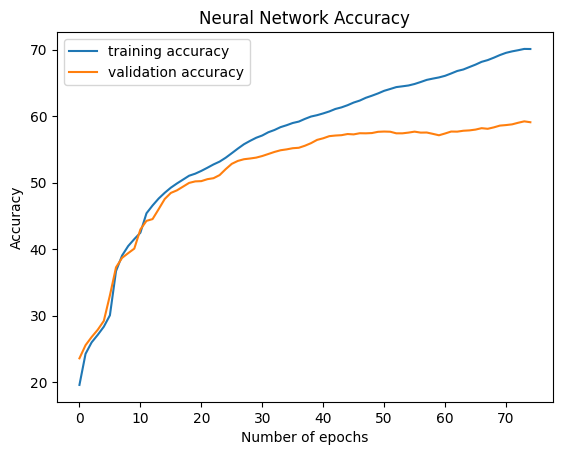

Test accuracy = 58.38% 

I went back to my highest % model, three convolutional layers, 12 channels, 24 channels, 36 channels (stride=1, padding=1, 3x3 kernel) ReLU() and MaxPooling() and changed the optimizer to Adagrad with a learning rate of .01 - this resulted in vanishing gradient where the loss started to converge at 2.00 where I'm assuming that the learning rate ended up shrinking too small where the model couldn't learn anything from this point. I then tested with RMSprop. RMSprop showed better results than Adagrad, which was expected... however, the results aren't better than what I found when using Adam as the model ended up not generalizing very well (40%). Adam has combined benefits of other optimizers, including RMSprop (https://medium.com/analytics-vidhya/this-blog-post-aims-at-explaining-the-behavior-of-different-algorithms-for-optimizing-gradient-46159a97a8c1) and I ultimately got a faster convergence rate with Adam while getting my highest accuracy model while using it (shown earlier in where I got 70% accuracy on the test set).

Lastly, I wanted to see the results of using SGD with this model and see if I could get better generalization. As a result, I found that convergence was much faster than I expected - getting to a loss of .1 within 15 epochs where Adam took 50 epochs to get to 0.2.
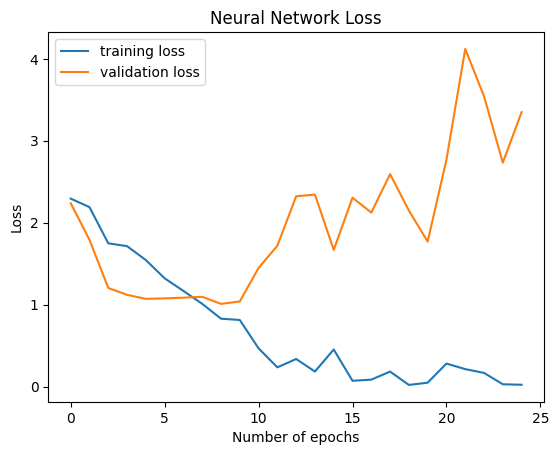
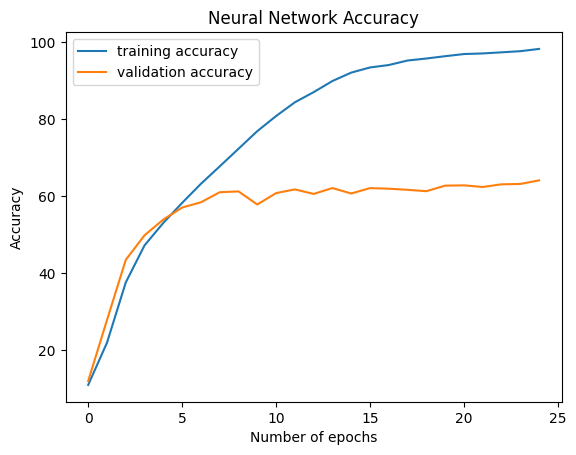

Test Accuracy: 63.12%

Seeing how generaliziation is an issue here, but convergence is fast, I decided to update my model to have more filters (more channels) and then a less complex classifer (only one hidden layer) which gave me my best results yet, in a training time of only 3 minutes.

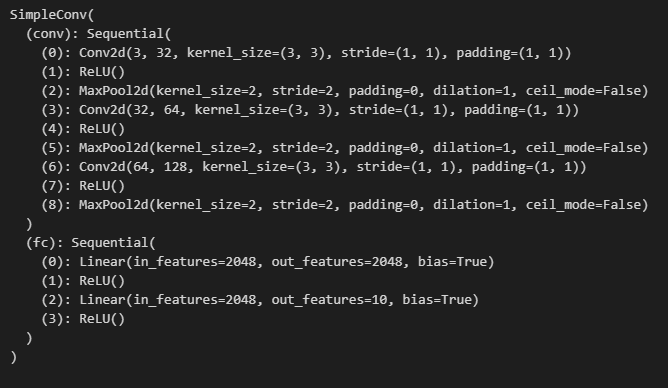

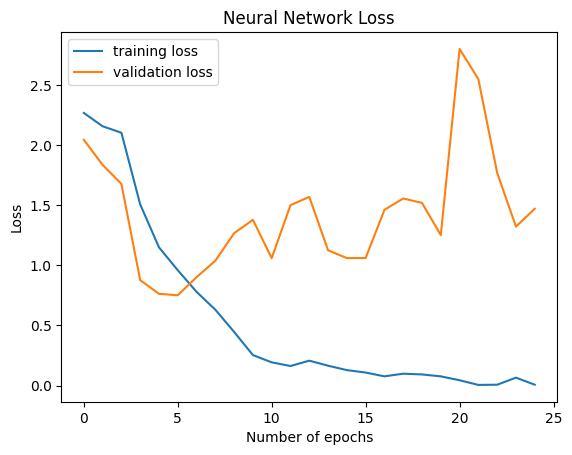
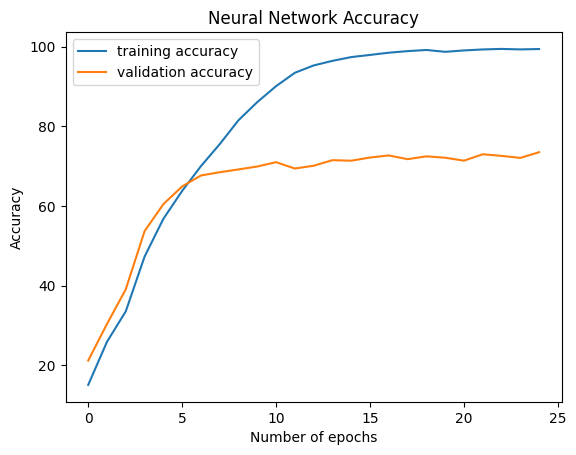

Test Accuracy: 71.94%

Seeing how my batch size is 32 here, I'm going to see if I can get a higher test accuracy by reducing the batch size to 10. This will increase training time, but seeing how it only takes me 3 minutes to train to get 70% accuracy, and overfitting occurs at epoch 10, this isn't an issue. However, after training I noticed that having a batch size of 10, and a learning rate of .1 made SGD have a hard of a time converging - I have a feeling this is most likely causing a "nosier" gradient, especially with the learning rate so high. There's more updates occuring with the model trying to update on smaller sets of data in each iteration.  

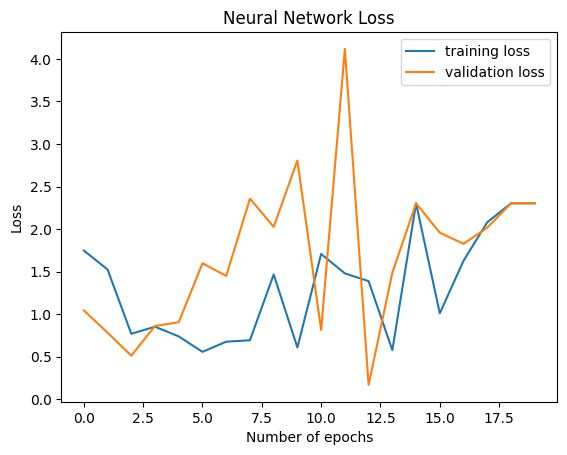
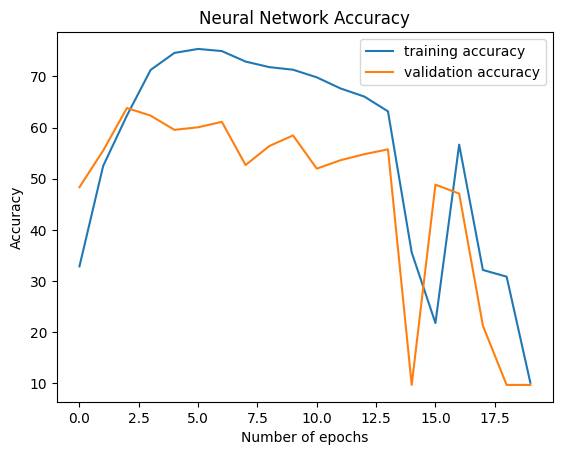

With this in mind, I'm going to try reducing the learning rate to .01 and see if that will help with this gradient issue. - As a result, this did. However, overfitting wasn't fixed and I ultimately ended up with similar results as when I had the learning rate at .1 and a batch size of 64.



### Resnet and Alexnet

In [152]:
import torch
from torch import nn

# Parameters
batch_size = 64
learning_rate=1e-1
nepochs = 10
LossFunction = nn.CrossEntropyLoss()

#l2
wd = .001 # Penalty to larger weights to help prevent overfitting

save_weights = nepochs - 5


channels=3

# Output size
nout=10

# Use GPU if avaiable
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))

    torch.cuda.set_per_process_memory_fraction(0.8, device=0)
else:
    device = torch.device("cpu")
    print("Using CPU")
    
    
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torch.utils.data import random_split

# From https://pytorch.org/hub/pytorch_vision_alexnet/
# Also works for resnet
preprocess = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

cifar10_dataset = datasets.CIFAR10(root='./', # here
                               train=True, # train split
                               download=True, # we want to get the data
                               transform=preprocess, # transform image using preprocess
                              )

# Split the data into a training data set, validation set, and a test set - first get sizes
# CIFAR10 has 50000 images, so I'll split the data up into 37500 for training, 7500 for validation
# and 5000 for testing
train_data_size = 40000
val_data_size = 10000

# Randomsplit with will split the data from cifar10 dataset into train, val, and test with their respective sizes  
train_dataset, val_dataset = random_split(cifar10_dataset, [train_data_size, val_data_size])

# We can now load the data with DataLoader from these datasets 
train_data = DataLoader(train_dataset,
                        batch_size=batch_size,
                        )

val_data = DataLoader(val_dataset,
                      batch_size=batch_size,
                      )


model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False).to(device)
# print(model)



Using GPU: NVIDIA GeForce RTX 2070 SUPER
Files already downloaded and verified


Using cache found in /home/dlu/.cache/torch/hub/pytorch_vision_v0.10.0


Type: <class 'list'>
Length: 2
More Types: <class 'torch.Tensor'>, <class 'torch.Tensor'>
Shapes: 64, 3, 224, 224]), 64])
Labels: tensor([1, 8, 3, 1, 9, 4, 1, 8, 9, 4, 8, 4, 5, 2, 7, 2, 9, 7, 4, 8, 6, 6, 6, 1,
        9, 1, 3, 6, 1, 2, 3, 6, 7, 5, 1, 3, 0, 9, 8, 9, 1, 4, 5, 4, 0, 8, 1, 5,
        2, 0, 3, 9, 7, 4, 8, 0, 8, 4, 0, 7, 5, 0, 6, 3])



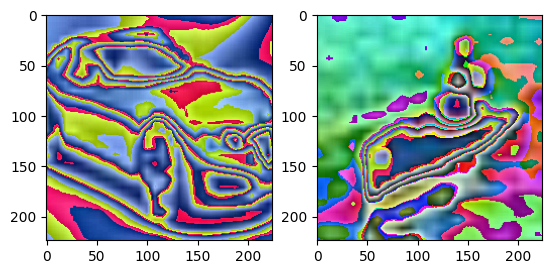

In [153]:
data = iter(train_data) # Let's iterate on it
single_point = next(data)
print(f"""Type: {type(single_point)}
Length: {len(single_point)}
More Types: {type(single_point[0])}, {type(single_point[1])}
Shapes: {single_point[0].shape}, {single_point[1].shape}
Labels: {single_point[1]}
""")

import matplotlib.pyplot as plt
from torchvision import transforms as T
ToPIL = T.ToPILImage() # Converting function
img0 = ToPIL(single_point[0][0])
img1 = ToPIL(single_point[0][1])
# Plotting
fig, axs = plt.subplots(1,2)
axs[0].imshow(img0)
axs[1].imshow(img1)

Epoch:   0%|          | 0/7 [00:00<?, ?epoch/s]

Epoch 0: loss: 1.4065371751785278
Validation Accuracy: 45.61
Epoch 1: loss: 0.9935643672943115
Validation Accuracy: 55.56
Epoch 2: loss: 0.8864331841468811
Validation Accuracy: 64.71
Epoch 3: loss: 0.6872468590736389
Validation Accuracy: 66.53
Epoch 4: loss: 0.7805514931678772
Validation Accuracy: 59.07
Epoch 5: loss: 0.30417168140411377
Validation Accuracy: 67.17
Epoch 6: loss: 0.26920875906944275
Validation Accuracy: 69.18


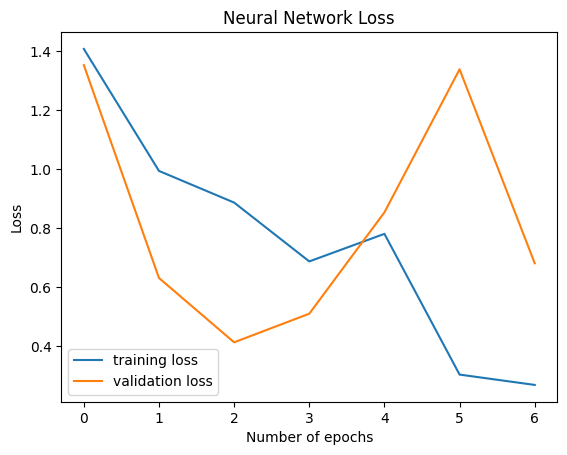

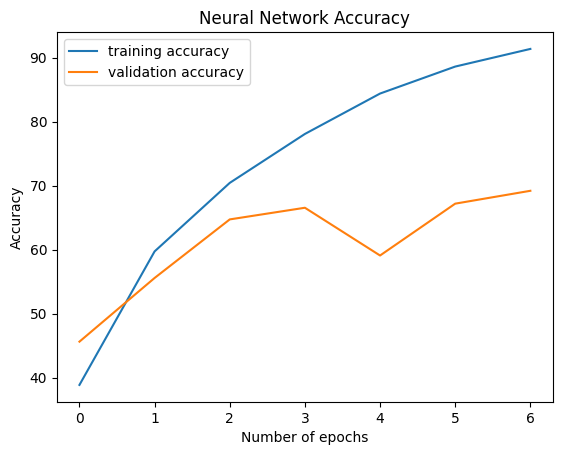

In [154]:
from torch import optim
from tqdm import tqdm, notebook # This is optional but useful
from torchvision import datasets
import matplotlib.pyplot as plt

torch.cuda.empty_cache()

nepochs = 7
# model.load_state_dict(torch.load("model_epoch_24.pt"))

wd = .001
learning_rate = .1
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=wd)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=.1)

loss_history = []
acc_history = []
val_loss_history = []
val_acc_history = []
for epoch in notebook.trange(nepochs,
                  desc="Epoch",
                  unit="epoch",
                  disable=False):
    correct = 0
    total = 0
    model.train()
    for (data, label) in tqdm(train_data,
                              desc="iteration",
                              unit="%",
                              disable=True):
        optimizer.zero_grad(set_to_none=True)
        data = data.to(device)
        label = label.to(device)
        out = model(data)
        loss = LossFunction(out, label)
        
        loss.backward()
        optimizer.step()
    
        # Used chatGPT to help write this accuracy code     
        _, predicted = torch.max(out.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
        
    accuracy = 100 * correct / total
    acc_history.append(accuracy)
    loss_history.append(loss.item())
    print(f"Epoch {epoch}: loss: {loss.item()}")
    if (epoch >= epoch - 10): # Save tensor information once we get towards the end
        torch.save(model.state_dict(), "model_epoch_{}.pt".format(epoch))
    
    
    # Validation
    model.eval() # No longer training - comparing loss and accuracy in our validation set
    correct = 0
    total = 0
    with torch.no_grad(): # Don't want to update the gradients
        for (data, label) in val_data:
            data = data.to(device)
            label = label.to(device)
            out = model(data)
            loss = LossFunction(out, label)

            # Used chatGPT to help write this accuracy code     
            _, predicted = torch.max(out.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            
        accuracy = 100 * correct / total
        val_acc_history.append(accuracy)
        val_loss_history.append(loss.item()) 
    
        print(f"Validation Accuracy: {accuracy}")           
          

plt.plot(loss_history, label='training loss')
plt.plot(val_loss_history, label='validation loss')
plt.title("Neural Network Loss")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(acc_history, label='training accuracy')
plt.plot(val_acc_history, label='validation accuracy')
plt.title("Neural Network Accuracy")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Files already downloaded and verified
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

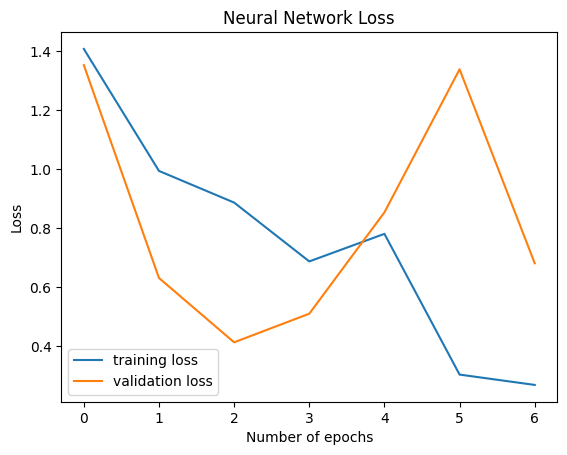

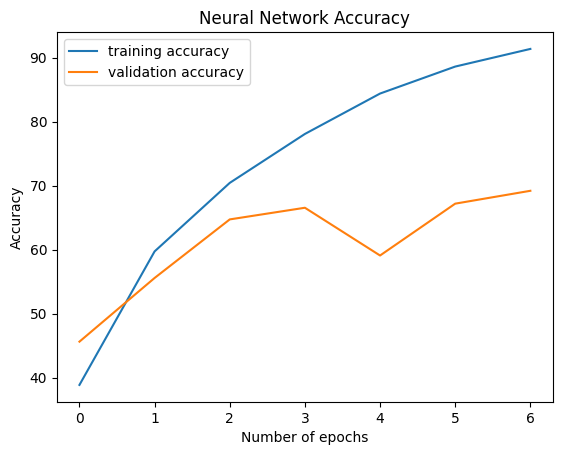

Total accuracy = 68.97%


In [155]:
cifar10_test_dataset = datasets.CIFAR10(root='./', # here
                               train=False, # train split
                               download=True, # we want to get the data
                               transform=preprocess, # put it into tensor format
                              )

test_data = DataLoader(cifar10_test_dataset,
                       batch_size=batch_size,
                       )

model.load_state_dict(torch.load("model_epoch_6.pt"))
print(model)

plt.plot(loss_history, label='training loss')
plt.plot(val_loss_history, label='validation loss')
plt.title("Neural Network Loss")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(acc_history, label='training accuracy')
plt.plot(val_acc_history, label='validation accuracy')
plt.title("Neural Network Accuracy")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

model.eval()
accuracy = 0
for (data, label) in test_data:
    data = data.to(device)
    label = label.to(device)
    out = model(data)
    answers = out.max(dim=1)[1]
    accuracy += (answers == label).sum()
print(f"Total accuracy = {accuracy / len(cifar10_test_dataset)*100:.2f}%")

### Results

I initially started training with a batch size of 64 and a learning rate of .01 for both Resnet and Alexnet. I trained them both for 25 epochs initially. 

With **Alexnet**, my results are as follows: 

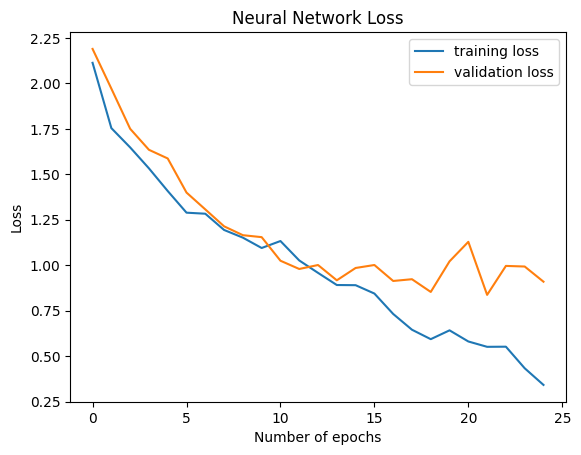
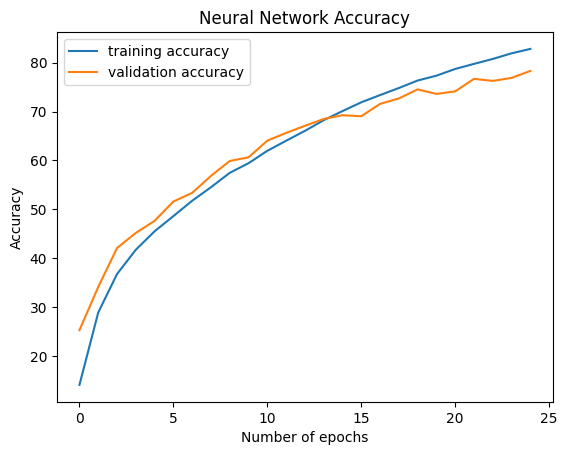

Test Accuracy: 78.00%

Training time took 31 minutes with 2070 Super. 

A couple things to point out about Alexnet is the classifier is more complex, and includes "Dropout" in it. It has a much larger Convolutional structure than what I had, and gets much deeper in the channel layers. 

I then tested with Resnet (on google colab) and got the following results: 
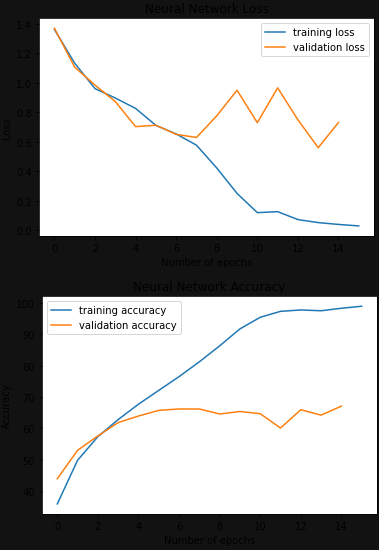

Test Accuracy: 66.07% and train time was 55 minutes

Seeing how overfitting is occuring here, I have a feeling this has to do with the model and it's overall complexity, causing weights to overfit to the training set. I'm going to now add weight decay of .0001 in my SGD optimizer and see how this will affect generalization. 

Ultimately this didn't have much of an effect and generalization started occuring after epoch 3. My assumption as to why Alexnet is performing better than Resnet is because Resnet is much deeper than Alexnet causing overfitting. Similar to how in my model I created from scratch, I found that when messing with the Convolutiona layer too much, adding more layers with different more filters got me worse results at times. However, with this in mind I decided to increase the learning rate to .1 and to try training again. This time, I got better results. After 10 epochs (a training time of 20 minutes), batch size of 64, learning rate of .1, SGD with weight decay of .0001 I got these results (Epochs 0-4 are cut off since I cut off training early and then started from there):

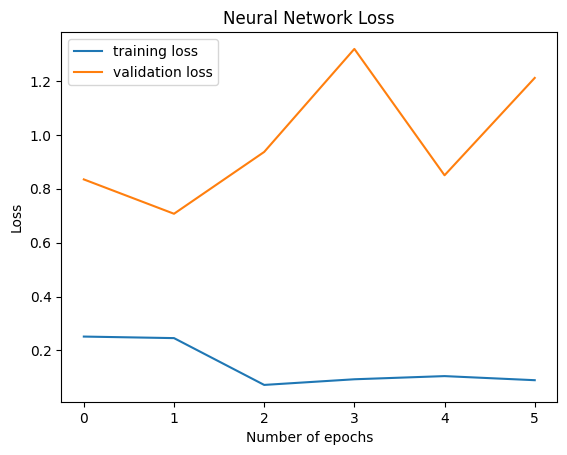
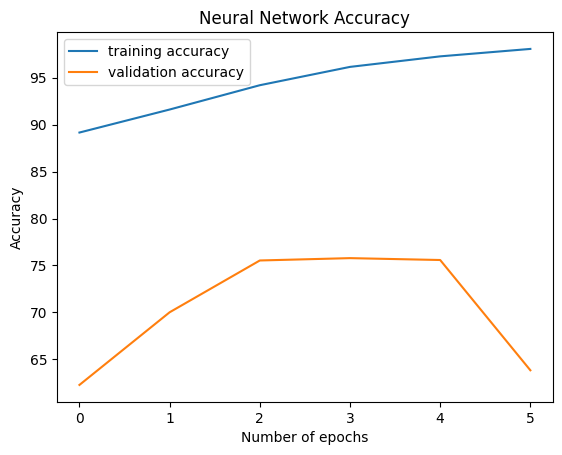

It would benefit to add a scheduler here to reduce learning rate, especially when using a learning rate of .1 at the beginning because it's clear that it has an affect on learning towards the end of the process. 

-- 

After seeing how AlexNet had 10% higher accuracy than my model, I want to add a few regularization techniques to my model. I'll first just add dropout to my model and see how that affects its ability to generalize. My assumption is that it'll increase in accuracy due to the nature of dropout 

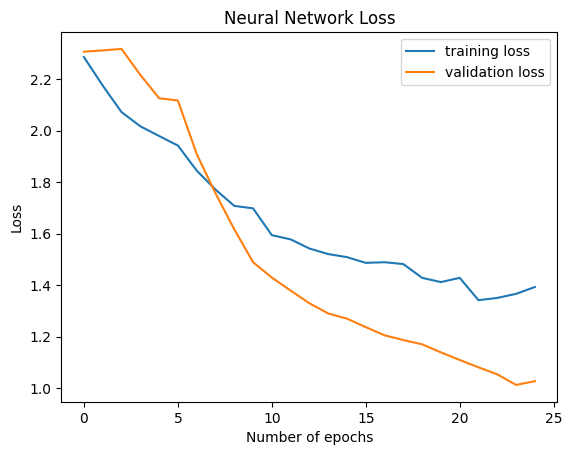
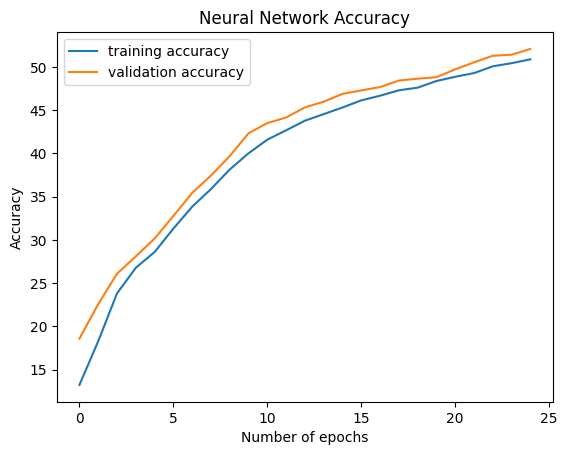

As a result I ended up getting pretty slow convergence compared to when I wasn't using weight_decay. Looking at a model I trained without weight_decay I got these results: 

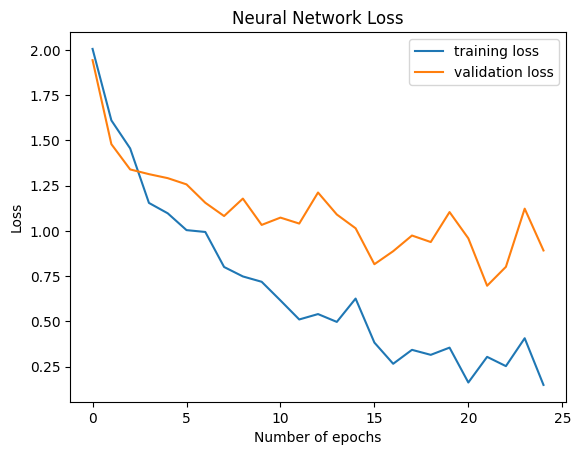
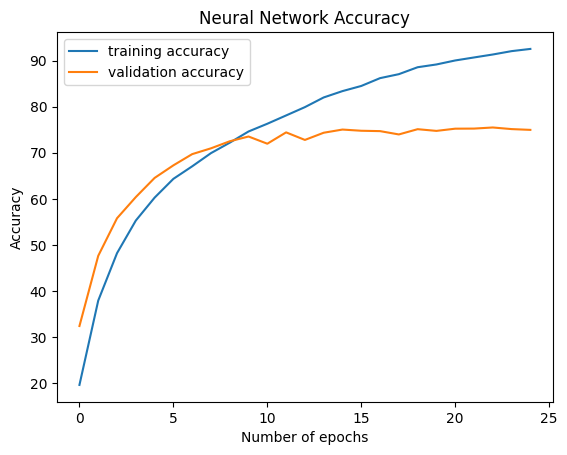

Test Accuracy: 75.22%

Clearly this had an affect. I'll address the learning rate later (since it's clearly too high towards the end of training). Seeing how dropout has affected generalization, I now want to add L2 (weight decay of .01) in to see if I can get better generalization. 

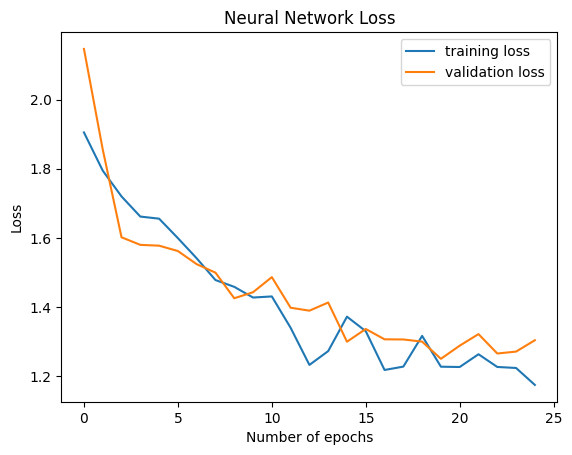
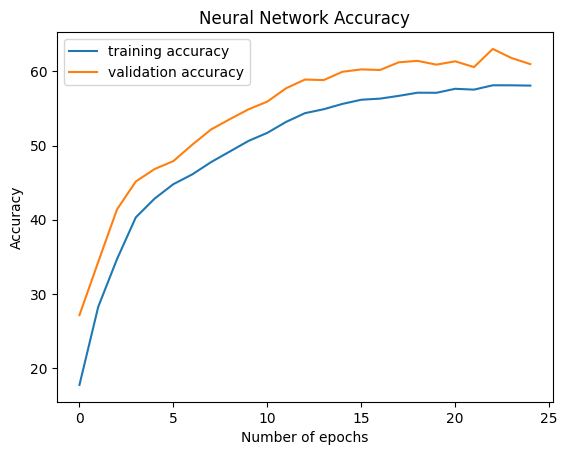

Test Accuracy: 62.55% 

Overall - This has proven to be most effective in terms of reducing overfitting, however it resulted in it settling at a local minimum due to the high weight decay. With this, I'm going to add a scheduler (StepLR - step_size=10, gamma=0.1) to both reduce the learning rate, and increase the weight decay over time. The results:

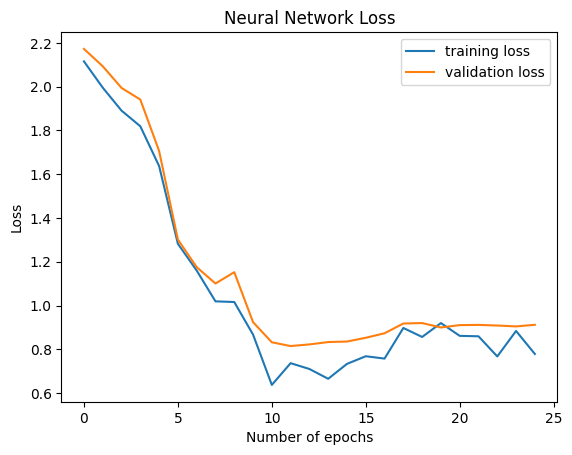
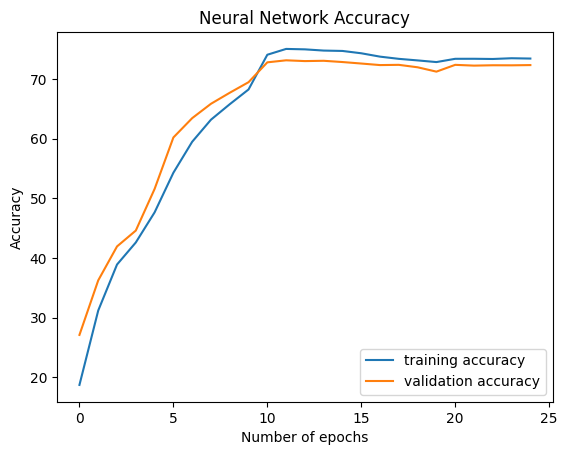

Test Accuracy: 76.33%

I changed the weight decay to .0025 and removed updating it, and found that adding the scheduler helped overfitting, and the model finds a minimum after epoch 12. Adding weight decay really helped here with overfitting -- but also keeping in mind this is paired with dropout. From my understanding, dropout is zeroing out nodes within a layer - this will help generalization by preventing certain weights getting too big, and helps prevent the model from not focusing on these nodes, and learns more features.


--


I decided to then try .001 weight decay with resnet, since it's fairly complex, and see the results on if it could generalize better now. I'll also do the same thing with Alexnet - my assumption is that Alexnet will at least get better results than before since it uses dropout (I decided to use .0025 with Alexnet).

With Resnet I found that I got slightly better results than when I didn't have weight decay (with a learning rate of .01):

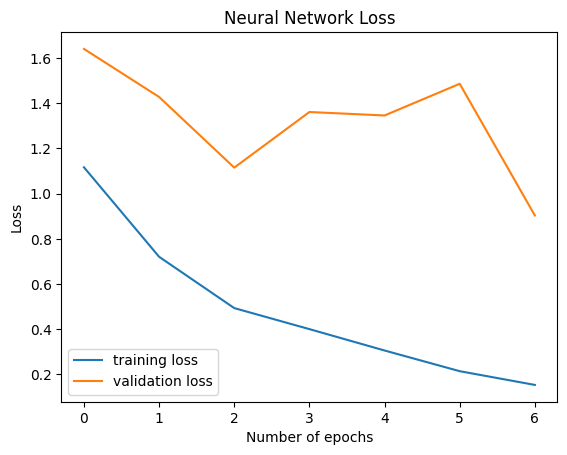
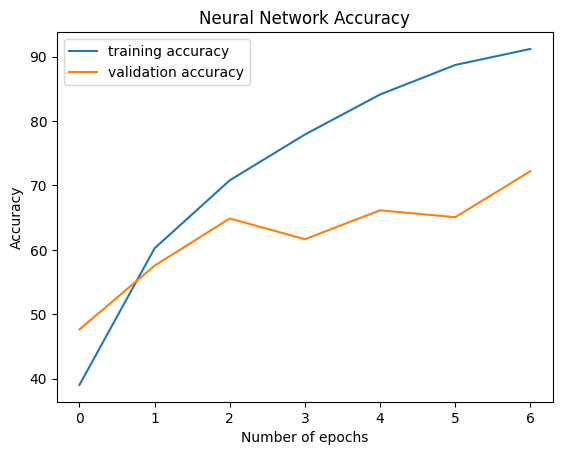

With Alexnet, I didn't train it long enough, but it's clear that the model is doing a good job of generalizing (given the accuracy it's given), however, it ended up converging slower and had lower accuracy than when I didn't have weight decay.  

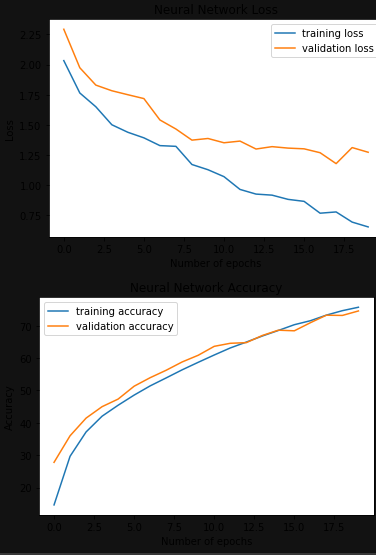

### Other DL Techniques

*I've applied these techniques to my model since it trains faster, and I can experiment with more.*

#### Learning Rate Scheduling

I've already done a few tests with learning rate (seen in the last cell) but I want to see how adjusting it with a higher gamma (.5) and a smaller step size (4) will affect it. I'm keeping in my weight decay (.0025) as well as dropout. I'm starting with a learning rate of .1

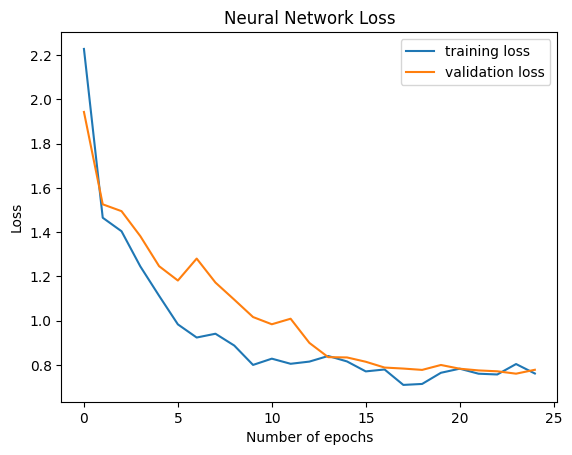
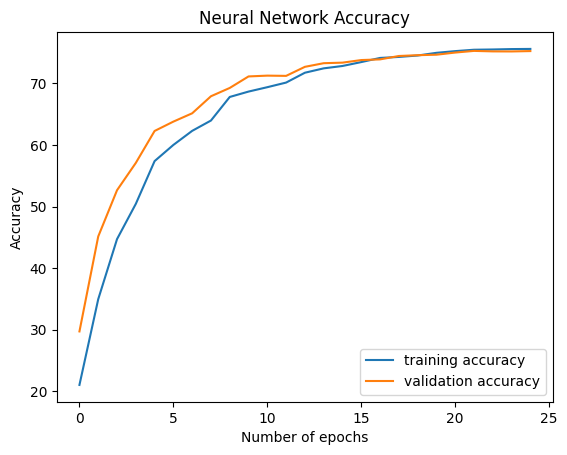

Test Accuracy: 74.56%

Doing this had a really great way of keeping test and validation accuracy close together and made sure there was no overfitting - which makes sense since if keeping the learning rate contained and reducing it as it gets closer it prevents the gradient from going all over the place as it gets closer to the minimum it's approaching. It also prevents it from "jumping out" and overfitting. However, it's still underfitting and getting only 75% accuracy. This most likely has to do with the model not being complex enough. 

#### Augmentation

I wanted to try augmenting the data to see if I could get more diversity in my data to help prevent overfitting, and to help my model learn more features to better generalize. Augmenting with RandomHorizontalFlip, and RandomCrop of 28x28 with a padding of 4, interestingly I found that the model did a good job keep the validation set close to the test set in accuracy, but it's underfitting quite a bit, which mostly probably has to do with the model not being complex enough.

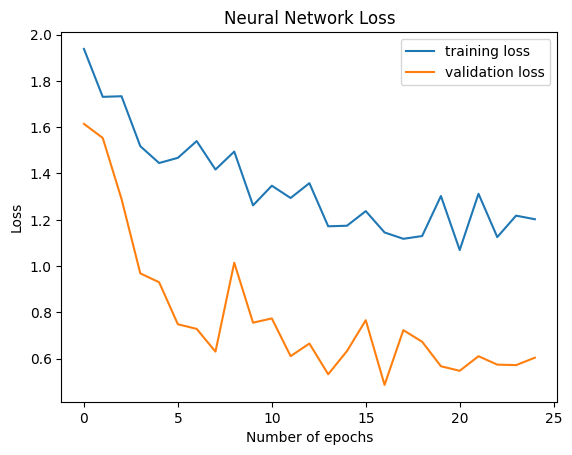
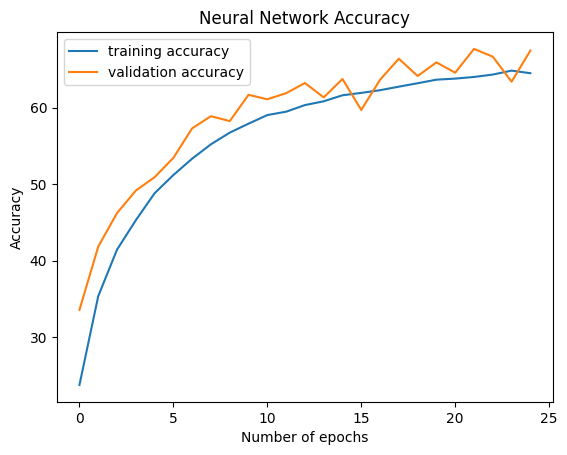

I decided to try this augmented data with learning rate scheduling as well, since I had the best results with that setup on the normal parameters - it's likely that the high learning rate is affecting the gradient and accuracy isn't able to improve because it's adjusting too much as it gets closer to a minimum, but only got around 70% accuracy. 


# Part 3 - Fine Tuning
------

In [2]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.datasets.folder import default_loader
import torchvision.transforms as T
import matplotlib.pyplot as plt
import os
from torch.utils.data import random_split
from torchvision.models.resnet import resnet50, ResNet50_Weights

class CUB200(Dataset):
  def __init__(self, annotations_file, images_file, img_dir, transform=None, loader=default_loader):
    self.img_labels = {}
    with open(annotations_file, "r") as f:
      for line in f:
        id, class_ = line.strip().split()
        self.img_labels[id] = class_
    
    self.images = {}
    with open(images_file, "r") as f:
      for line in f:
        id, image_path = line.strip().split()
        self.images[id] = image_path
    
    self.img_dir = img_dir
    self.transform = transform
    self.loader=loader
  
  def __len__(self):
    return len(self.img_labels)
  
  def __getitem__(self, index):
    img_path = os.path.join(self.img_dir, self.images[str(index + 1)])
    image = self.loader(img_path)
    label = self.img_labels[str(index + 1)]
    
    if self.transform:
      image = self.transform(image)
  
    return image, torch.tensor(int(label)-1) # Convert labels to tensors, and subtract 1 for convention purposes (to start at 0)
 
root_dir = "CUB_200_2011"
annotations_file = root_dir + "/image_class_labels.txt"  
img_dir = root_dir + "/images"
images_file = root_dir + "/images.txt"

transform = T.Compose ([
  # T.Resize((256)),
  T.CenterCrop(224),
  T.ToTensor(),
  T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

cub_data = CUB200(annotations_file=annotations_file, images_file=images_file, img_dir=img_dir, transform=transform)

print(len(cub_data))

train_data_size = 9000
val_data_size = 1688
test_data_size = 1100

print(train_data_size + val_data_size + test_data_size)

# Randomsplit with will split the data from cifar10 dataset into train and validation set 
train_dataset, val_dataset, test_dataset = random_split(cub_data, [train_data_size, val_data_size, test_data_size])


batch_size = 10

train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")
    
torch.cuda.set_per_process_memory_fraction(0.5, device=0)

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).to(device)



11788
11788
Using GPU: NVIDIA GeForce RTX 2070 SUPER


Sources: \
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html\
https://github.com/TDeVries/cub2011_dataset/blob/master/cub2011.py

Used the the pytorch tutorial to write most of the code - used the github to figure out to use default_loader/ loader to convert the image to PIL Images.

Type: <class 'list'>
Length: 2
More Types: <class 'torch.Tensor'>, <class 'torch.Tensor'>
Shapes: 10, 3, 224, 224]), 10])
Labels: tensor([188, 139, 126,   8,  79, 108,  80, 116, 179,  81])



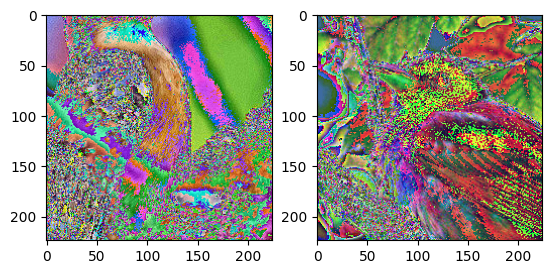

In [25]:
data = iter(train) # Let's iterate on it
single_point = next(data)
print(f"""Type: {type(single_point)}
Length: {len(single_point)}
More Types: {type(single_point[0])}, {type(single_point[1])}
Shapes: {single_point[0].shape}, {single_point[1].shape}
Labels: {single_point[1]}
""")

import matplotlib.pyplot as plt
from torchvision import transforms as T
ToPIL = T.ToPILImage() # Converting function
img0 = ToPIL(single_point[0][0])
img1 = ToPIL(single_point[0][1])
# Plotting
fig, axs = plt.subplots(1,2)
axs[0].imshow(img0)
axs[1].imshow(img1)

In [1]:
import torch
from torch import nn
from torch import optim
from tqdm import tqdm, notebook # This is optional but useful
from torchvision import datasets
import matplotlib.pyplot as plt

torch.cuda.empty_cache()

learning_rate=1e-1
LossFunction = nn.CrossEntropyLoss()
nepochs = 10
learning_rate = .1
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


loss_history = []
acc_history = []
val_loss_history = []
val_acc_history = []
for epoch in notebook.trange(nepochs,
                  desc="Epoch",
                  unit="epoch",
                  disable=False):
    correct = 0
    total = 0
    model.train()
    for (data, label) in tqdm(train,
                              desc="iteration",
                              unit="%",
                              disable=True):
        optimizer.zero_grad(set_to_none=True)
        data = data.to(device)
        label = label.to(device)
        out = model(data)
        loss = LossFunction(out, label)
        
        loss.backward()
        optimizer.step()
    
        # Used chatGPT to help write this accuracy code     
        _, predicted = torch.max(out.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
        
    accuracy = 100 * correct / total
    acc_history.append(accuracy)
    loss_history.append(loss.item())
    print(f"Epoch {epoch}: loss: {loss.item()}")
    if (epoch >= epoch - 10): # Save tensor information once we get towards the end
        torch.save(model.state_dict(), "model_epoch_{}.pt".format(epoch))
    
    
    # Validation
    model.eval() # No longer training - comparing loss and accuracy in our validation set
    correct = 0
    total = 0
    with torch.no_grad(): # Don't want to update the gradients
        for (data, label) in validation:
            data = data.to(device)
            label = label.to(device)
            out = model(data)
            loss = LossFunction(out, label)

            # Used chatGPT to help write this accuracy code     
            _, predicted = torch.max(out.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            
        accuracy = 100 * correct / total
        val_acc_history.append(accuracy)
        val_loss_history.append(loss.item()) 
    
        print(f"Validation Accuracy: {accuracy}")           
          

plt.plot(loss_history, label='training loss')
plt.plot(val_loss_history, label='validation loss')
plt.title("Neural Network Loss")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(acc_history, label='training accuracy')
plt.plot(val_acc_history, label='validation accuracy')
plt.title("Neural Network Accuracy")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

NameError: name 'model' is not defined

In [30]:
model.eval()

accuracy = 0
for (data, label) in test:
    data = data.to(device)
    label = label.to(device)
    out = model(data)
    answers = out.max(dim=1)[1]
    accuracy += (answers == label).sum()
print(f"Total accuracy = {accuracy / len(cub_data)*100:.2f}%")

Total accuracy = 7.12%


# Results

First time running with the pretrained model these are the results I got from 10 epochs of training (roughly 20 minutes of training)

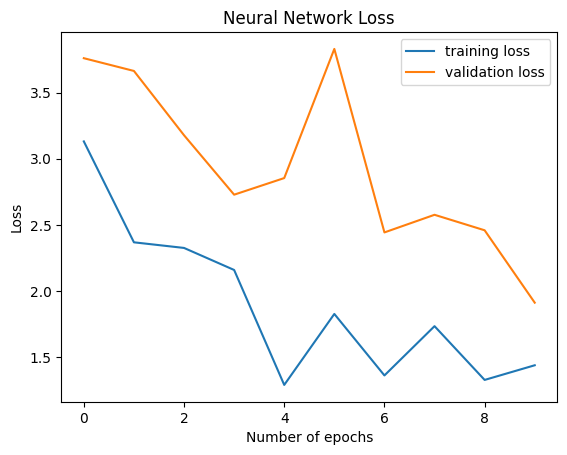
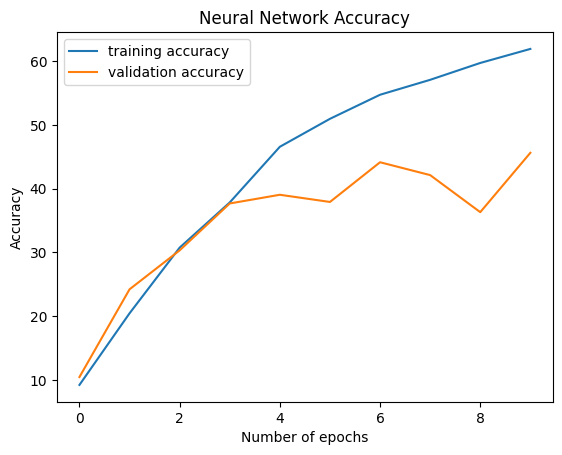

I noticed pretty poor results, so I double checked what the starting accuracy was and it was around .01% which is basically the same thing as starting from scratch. So I decided to change how I was transforming the data since I figured that had to be the reason for this. I was originally resizing the image down - but now I'll just do a centercrop down to 224 (since that's the image size Resnet50 was trained on). After 10 epochs of training these are the results:

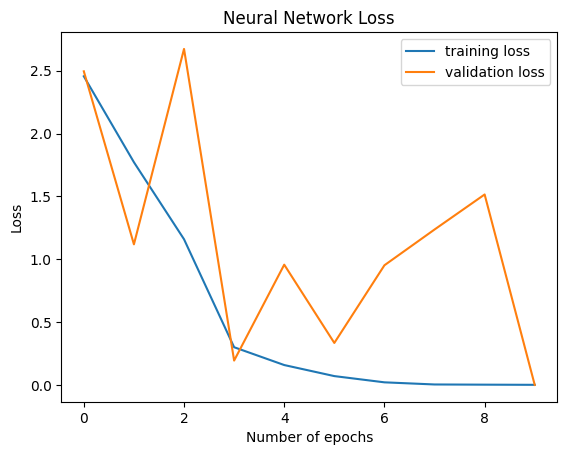
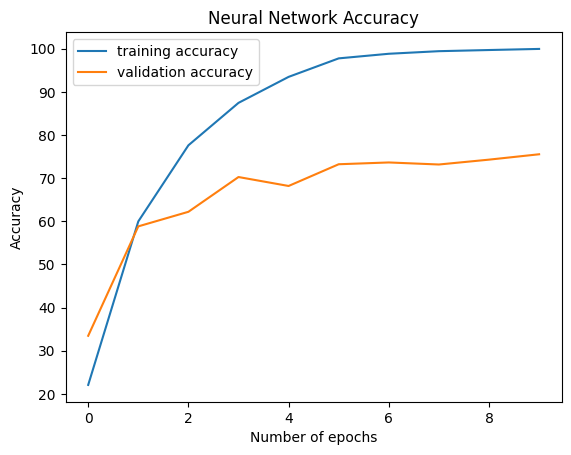

It'd probably make sense to train with a smaller learning rate (I was using .1) (and) or using a learning rate scheduler, to reduce the learning rate after 2 epochs or so since it's already pre-trained. 

I've been training with large learning rates mainly to get faster results, however seeing most loss graphs, I probably should have been training with lower learning rates. 





# Part 4 - KNN
--------

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T


cifar10_dataset = datasets.CIFAR10(root='./', # here
                               train=True, # train split
                               download=True, # we want to get the data
                               transform=T.ToTensor(), # put it into tensor format
                              )

test_dataset = datasets.CIFAR10(root='./',
                                train=False,
                                download=True,
                                transform=T.ToTensor())

train_size = 20000
test_size = 10000

train_data = DataLoader(cifar10_dataset,
                        batch_size=train_size,
                        )

test_data = DataLoader(test_dataset,
                       batch_size=test_size)

from sklearn.neighbors import KNeighborsClassifier

k1 = KNeighborsClassifier(n_neighbors=1, p=1)
k3 = KNeighborsClassifier(n_neighbors=3, p=1)
k5 = KNeighborsClassifier(n_neighbors=5, p=1)
k10 = KNeighborsClassifier(n_neighbors=10, p=1)

In [ ]:
import numpy as np

trd = iter(train_data)
ted = iter(test_data)

train, train_label = next(trd)
test, test_label = next(ted)

train = train.view(train_size, -1)
test = test.view(test_size, -1)

test_label = test_label.numpy()

import time

start = time.time()

k1.fit(train, train_label)
p = k1.predict(test)
print(f"k = {1}, Accuracy: {np.mean(p == test_label)}%")

end = time.time()

print(f"Time taken: {round(end - start, 2)} seconds")


Using L1 these are the results I got:

k = 1, Accuracy: 0.3385%\
Time taken: 538.83 seconds

k = 3, Accuracy: 0.3333%\
Time taken: 572.49 seconds

k = 5, Accuracy: 0.3396%\
Time taken: 530.34 seconds

k = 10, Accuracy: 0.3455%\
Time taken: 526.93 seconds


Using L2 these are the results I got:


k = 1, Accuracy: 0.3539%\
Time taken: 97.94 seconds

k = 3, Accuracy: 0.3303%\
Time taken: 106.63 seconds

k = 5, Accuracy: 0.3398%\
Time taken: 105.32 seconds

k = 10, Accuracy: 0.3386%\
Time taken: 102.5 seconds



I immediately noticed that L2 is much faster than L1, as I could train on the whole dataset with L2 in around 100 seconds. However, L1 shows to have similar accuracy to L2 when using less training data (half). 

Something else worth noting is the drop in accuracy when using 3 and 5 for the value of k. My assumption for this has to do with the number of classes. By using 1, it makes it so the first choice is what's used for the class estimate, but by adding 3 and 5, the other two, to four images could potentially bring in other class estimates that negate the closest data point and cause it to guess incorrectly. As for why the accuracy is still less than 35% when using 10 could follow this same logic, but I would have expected it to be slightly higher since the number of classes is 10.

-----

Source:
https://github.com/Kulbear/pytorch-the-hard-way/blob/master/Solutions/Nearest%20Neighbor.ipynb

I used this to help write the code for the KNN classifier.
